In [4]:
import hazelbean as hb
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

import os

In [77]:
ssp_list = ['ssp1','ssp2','ssp3','ssp4','ssp5']
rcp_list = ['26','45','60','60','85']
gcm_list = ['cc','gs','he','mr']

## Theory

/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


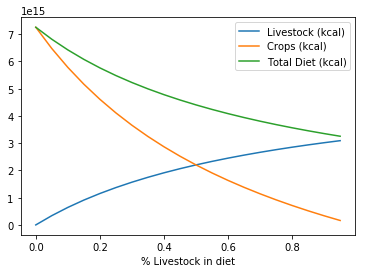

In [2]:
#pct_DietLS2050 = 0.15
df = pd.DataFrame(columns=['% Livestock in diet','Livestock (kcal)','Crops (kcal)','Total Diet 2050 (kcal)'])

Production = 9.1e15
pct_Prodfood = 0.52
feed_conversion_factor = 2.293651
LS2000 = 1.1e15

FoodCropsKcal2000 = 4.7684e+15


for pct_DietLS2050 in np.arange(0,1,0.05,dtype=float):
    LS_2050 = pct_DietLS2050 * (Production*pct_Prodfood + feed_conversion_factor*LS2000) / (1 + pct_DietLS2050*(feed_conversion_factor-1)) 
    
    
    FoodCrops_2050 = Production * pct_Prodfood + feed_conversion_factor * (LS2000-LS_2050) 

    TotDiet_2050 = FoodCrops_2050 + LS_2050
    
    df = df.append({'% Livestock in diet':pct_DietLS2050,
                   'Livestock (kcal)':LS_2050,
                   'Crops (kcal)':FoodCrops_2050,
                   'Total Diet (kcal)':TotDiet_2050},ignore_index=True)

df.plot(x='% Livestock in diet',y=['Livestock (kcal)','Crops (kcal)','Total Diet (kcal)']);#,figsize(10,20))
    

# Global

## Data

See Method - Caloric Sufficiency Calc

In [ ]:
#Caloric requirement
#ADER = 2355 (w.o fish 2320)

caloric_req = 2320 * 1e3 * 365.25 #in cal/capita/yr

In [125]:
# Population 

def get_total_pop(ssp):
    '''ssp: 2000 or ssp'''
    
    pop_dir = '../Data/intermediate/Population_csvs'
    if ssp.startswith('ssp'):
        pop = pd.read_csv(os.path.join(pop_dir,'adjusted_'+ssp+'.csv'))
    else:
        pop = pd.read_csv(os.path.join(pop_dir,ssp+'.csv'))
    pop = pop.set_index('pixel_id')
    pop_tot = pop['gpw_population'].sum()
    return pop_tot

In [16]:
def get_total_prod(ssp):
    '''ssp: 2000 or ssp'''
    
    results_dir = '../Data/outputs/Model_results/All_Change/xgb3_Allinputs'
    if ssp == '2000':
        rez = pd.read_csv(os.path.join(results_dir,'ssp1_composite.csv'))
        return rez['Calories 2000'].sum()
    
    else:
        rez = pd.read_csv(os.path.join(results_dir,ssp+'_composite.csv'))
        #rez = rez.set_index('pixel_id')
        return rez['Calories 2050'].sum()

## Caloric Sufficiency equations

In [80]:
def calc_CalSuff(prod_available, LS, pop,
            caloric_req = (2320*1e3*365.25) #in cal/capita/yr
           ):
    ''' prod_available (for Food not Feed + accounting for losses) - in Calories
        LS : animal calories availables
        pop : in capita
        caloric_req : default values is ADER=2320 kcal/cap/d (without fish)
        
        This is all per year
    '''
    return (prod_available + LS) / (caloric_req * pop)
    

## Global caloric sufficiency 

### 2000

In [100]:
pctLS_2000 = .19
LS_2000 = 1.1483e15*1e3 #calories

pct_Prod_Food = .52


pop_2000 = get_total_pop('2000')
prod_2000 = get_total_prod('2000') # calories

In [103]:
prod_available = prod_2000*pct_Prod_Food

global_CalSuff_2000 = calc_CalSuff(prod_available,
                       LS_2000,
                       pop_2000)

global_CalSuff_2000

1.9568988513886614

### SSPs

In [51]:
feed_conversion_factor = 2.3

# Data source: Bodirsky : share of calories in diet from animal products
pctLS_2050 = .19 #Assuming cst

In [81]:
def global_CalSuff_2050(ssp,
                        pctLS_2050 = .19):
    
    prod_2050 = get_total_prod(ssp)
    
    LS_2050 = pctLS_2050 * (prod_2050*pct_Prod_Food + feed_conversion_factor*LS_2000) / (1 + pctLS_2050*(feed_conversion_factor-1)) 

    feed_now_food = feed_conversion_factor * (LS_2000-LS_2050)
    
    prod_available = prod_2050*pct_Prod_Food + feed_now_food
    
    pop = get_total_pop(ssp)

    calsuff = calc_CalSuff(prod_available,
                           LS_2050,
                           pop)
    
    return calsuff


In [121]:
CalSuff_df = pd.DataFrame(columns=['ssp','global_CalSuff','pctLS'])

In [122]:
for ssp in ssp_list:
    for pctLS_2050 in [0,.05,.1,.11,.12,.13,.14,.15,.16,.17,.18,.19,.20,.21,.22,.23,.25,.30]:
        
        CalSuff = global_CalSuff_2050(ssp,
                                     pctLS_2050)

        CalSuff_df = CalSuff_df.append({'ssp':ssp,'global_CalSuff':CalSuff,'pctLS':pctLS_2050},ignore_index=True)

### Plot

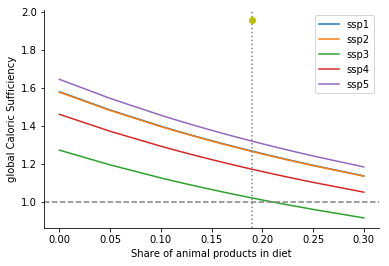

In [123]:
fig, ax = plt.subplots()

for ssp, grp in CalSuff_df.groupby(['ssp']):
    ax = grp.plot(ax=ax, kind='line', x='pctLS', y='global_CalSuff', label=ssp)

plt.axvline(x=.19,linestyle=':',color='grey')
plt.axhline(y=1,linestyle='--',color='grey')

# Baseline
plt.plot(.19, global_CalSuff_2000, 'yo') 

#Prettify
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('global Caloric Sufficiency');
plt.xlabel('Share of animal products in diet');
plt.legend(loc='best');


# By country

In [131]:
countries = pd.read_csv('../Data/intermediate/Crop_csvs/country_ids.csv')
countries = countries.set_index('pixel_id')
countries.head()

,Unnamed: 0,country_id,land_mask
pixel_id,,,
330087,330087,91.0,1
330088,330088,91.0,1
330089,330089,91.0,1
330090,330090,91.0,1
334378,334378,91.0,1


In [139]:
countries_ids = countries['country_id'].unique()

In [145]:
# Load countries and population data if it hasn't been done before
try:
    countries
except NameError:
    countries = pd.read_csv('../Data/intermediate/Crop_csvs/country_ids.csv')
    countries = countries.set_index('pixel_id')

try:
    pop #### MUST CHANGE PER SSP
    
except NameError:
    pop_dir = '../Data/intermediate/Population_csvs'
    pop = pd.read_csv(os.path.join(pop_dir,'adjusted_'+ssp+'.csv'))
    pop = pop.set_index('pixel_id')

In [132]:
pop_dir = '../Data/intermediate/Population_csvs'
pop = pd.read_csv(os.path.join(pop_dir,'adjusted_'+ssp+'.csv'))
pop = pop.set_index('pixel_id')

pop.head()

,Unnamed: 0,gpw_population,land_mask
pixel_id,,,
330087,330087,0,1
330088,330088,0,1
330089,330089,0,1
330090,330090,0,1
334378,334378,0,1


In [135]:
pop = pop.merge(countries[['country_id']],how='left',right_index=True,left_index=True)
pop.head()

,Unnamed: 0,gpw_population,land_mask,country_id
pixel_id,,,,
330087,330087,0,1,91.0
330088,330088,0,1,91.0
330089,330089,0,1,91.0
330090,330090,0,1,91.0
334378,334378,0,1,91.0


In [ ]:
# Population 

def get_total_pop(ssp):
    '''ssp: 2000 or ssp'''
    
    pop_dir = '../Data/intermediate/Population_csvs'
    if ssp.startswith('ssp'):
        pop = pd.read_csv(os.path.join(pop_dir,'adjusted_'+ssp+'.csv'))
    else:
        pop = pd.read_csv(os.path.join(pop_dir,ssp+'.csv'))
    pop = pop.set_index('pixel_id')
    pop_tot = pop['gpw_population'].sum()
    return pop_tot